In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2

In [5]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_dataset/no/28 no.jpg  
  inflati

          Count
Tumor       155
No tumor     98


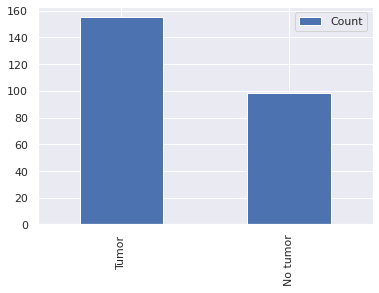

In [7]:
data_path = "/content/brain_tumor_dataset/"
    

sns.set_theme()
count = pd.DataFrame({"Count": [len(os.listdir(data_path + "yes")), len(os.listdir(data_path + "no"))]}, index=["Tumor", "No tumor"])
# count = pd.DataFrame({"Tumor": yes, "No tumor": no}, index=["Count"])
print(count.head())

count.plot(kind="bar")

In [8]:
pip install imagesize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


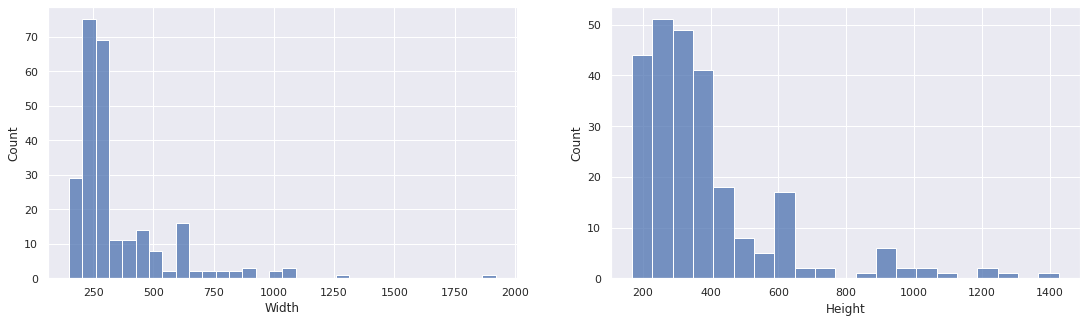

In [9]:
import imagesize

ws = []
hs = []
for cat in ["yes", "no"]:
    for image in os.listdir(data_path + cat):
        w, h = imagesize.get(data_path + cat + "/" + image)
        ws.append(w)
        hs.append(h)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5)
sns.histplot(pd.DataFrame({"Width": ws}), x="Width", ax=axs[0])
sns.histplot(pd.DataFrame({"Height": hs}), x="Height", ax=axs[1])

Text(0.5, 1.0, 'No tumor')

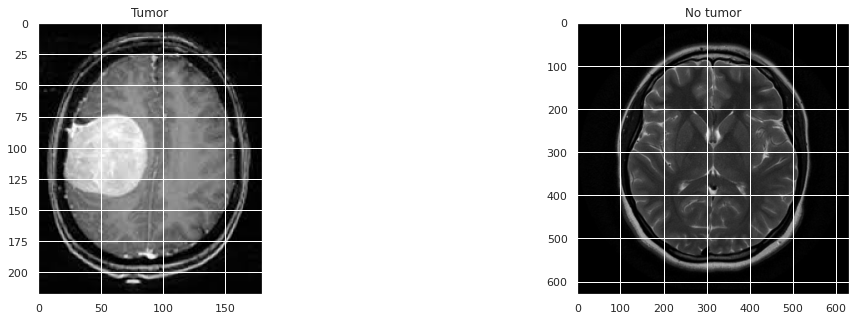

In [11]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5)

axs[0].imshow(cv2.imread(data_path + "yes/Y1.jpg"))
axs[0].set_title("Tumor")

axs[1].imshow(cv2.imread(data_path + "no/1 no.jpeg"))
axs[1].set_title("No tumor")

In [12]:
IMG_SIZE = 256
BATCH_SIZE = 32

In [13]:
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=["no", "yes"],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=["no", "yes"],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False
)


Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.


In [14]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import layers


data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2, 0.2)
])

def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
#     model = EfficientNetV2B1(include_top=False, input_tensor=inputs, weights="imagenet")
    model = MobileNetV2(include_top=False, weights="imagenet", input_tensor=x)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="sigmoid", name="pred")(x)
    model = tf.keras.Model(inputs, outputs, name="EfficientNetB0")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["binary_accuracy"])
    return model

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint


model = build_model()
EPOCHS = 100
model_path = "./brain_tumor_detection_mobileNetV2.hdf5"

model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.fit(train_dataset, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_dataset, verbose=1, callbacks=[model_checkpoint_callback], shuffle=False)
model.save("mobilenet.h5")

Epoch 1/100
7/7 [==============================] - 19s 620ms/step - loss: 0.7075 - binary_accuracy: 0.6650 - val_loss: 0.8245 - val_binary_accuracy: 0.5200
Epoch 2/100
7/7 [==============================] - 2s 284ms/step - loss: 0.5546 - binary_accuracy: 0.7685 - val_loss: 1.1476 - val_binary_accuracy: 0.4400
Epoch 3/100
7/7 [==============================] - 2s 283ms/step - loss: 0.3939 - binary_accuracy: 0.8325 - val_loss: 1.2393 - val_binary_accuracy: 0.4100
Epoch 4/100
7/7 [==============================] - 2s 293ms/step - loss: 0.2991 - binary_accuracy: 0.8793 - val_loss: 1.3879 - val_binary_accuracy: 0.4000
Epoch 5/100
7/7 [==============================] - 2s 297ms/step - loss: 0.2381 - binary_accuracy: 0.9113 - val_loss: 1.6552 - val_binary_accuracy: 0.3900
Epoch 6/100
7/7 [==============================] - 2s 280ms/step - loss: 0.2189 - binary_accuracy: 0.9089 - val_loss: 2.1184 - val_binary_accuracy: 0.3900
Epoch 7/100
7/7 [==============================] - 2s 276ms/step - lo

In [18]:
model.load_weights(model_path)
model.evaluate(val_dataset)

2/2 [==============================] - 0s 78ms/step - loss: 0.8245 - binary_accuracy: 0.5200


[0.8245108127593994, 0.5199999809265137]

In [20]:
from keras.models import model_from_json
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('mobilenet_model.json', 'w') as json_file:
    json_file.write(json_model)
